In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

from time import sleep
from skimage.draw import line
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

warnings.filterwarnings('ignore')

In [2]:
client = RemoteAPIClient()
sim = client.require('sim')

# Laser Functions

In [3]:
def read_sensor_data(range_data_signal_id="hokuyo_range_data", 
                    angle_data_signal_id="hokuyo_angle_data"):

    # the first call should be non-blocking to avoid getting out-of-sync angle data
    string_range_data = sim.getStringSignal(range_data_signal_id)
    string_angle_data = sim.getStringSignal(angle_data_signal_id)

    # check the if both data were obtained correctly
    if string_range_data and string_angle_data :
        # unpack data from range and sensor messages
        raw_range_data = np.array(sim.unpackFloatTable(string_range_data))
        raw_angle_data = np.array(sim.unpackFloatTable(string_angle_data))

        # noise_affected = np.random.random(raw_angle_data.size) > 0.9
        # raw_range_data[noise_affected] += np.random.random(noise_affected.sum()) * 0.2 - 0.1
        
        return raw_range_data, raw_angle_data

    # return none in case were nothing was gotten from the simulator
    return None, None

# Control Functions

In [4]:
def stop_non_holonomic_wheels(left_wheel:int, right_wheel:int) -> None:
    """
    Função destinada a parar o robô
    
    :param right_wheel: handle para o motor da roda direita
    :param left_wheel: handle para o motor da roda esquerda
    :return: None
    """
    sim.setJointTargetVelocity(left_wheel, 0)
    sim.setJointTargetVelocity(right_wheel, 0)

def non_holonomic_control(v:float, left_wheel:int, right_wheel:int) -> None:
    """
    Função destinada a levar o robo até certa posição
    
    :param v: velocidade aplicada sobre cada roda
    :param left_wheel: handle para o motor da roda esquerda
    :param right_wheel: handle para o motor da roda direita
    :return: None
    """
    sim.setJointTargetVelocity(left_wheel, v)
    sim.setJointTargetVelocity(right_wheel, v)

In [5]:
def get_shortest_rotation(current_orientation:float, target_orientation:float) -> int:
    """
    Função destinada a encontrar o sentido que otimiza a rotação do robô
    
    :param current_orientation: ângulo, em radianos, que nosso robô se encontra
    :param target_orientation: ângulo, em radianos, que nosso robô deseja se posicionar
    :return: 
           -1 -> sentido horário
            1 -> sentido antihorário
    """
    full_rot = 2 * np.pi

    current = current_orientation % full_rot
    target = target_orientation % full_rot
    
    difference = target - current
    
    if difference > np.pi:
        difference -= full_rot
    elif difference < -np.pi:
        difference += full_rot
    
    # Determine the direction to rotate
    if difference > 0:
        return 1
    else:
        return -1

def rotate_robot(v:float, robot:int, left_wheel:int, right_wheel:int, theta_obj:float) -> None:
    """
    Função destinada a rotacionar o robô até certo orientação

    :param v: velocidade aplicada sobre cada roda
    :param robot: handle para o robô
    :param left_wheel: handle para o motor da roda esquerda
    :param right_wheel: handle para o motor da roda direita  
    :param theta_obj: ângulo, em radianos, que o robô deseja alcançar
    :return: None
    """
    theta = sim.getObjectOrientation(robot)[2]

    while not (theta_obj - 0.02 < theta < theta_obj + 0.02):
        clockwise = get_shortest_rotation(theta, theta_obj)
        sim.setJointTargetVelocity(left_wheel, -2 * clockwise)
        sim.setJointTargetVelocity(right_wheel, 2 * clockwise)
        theta = sim.getObjectOrientation(robot)[2]
    non_holonomic_control(v, left_wheel, right_wheel)

def find_rotation(x:int, y:int, x_goal:int, y_goal:int) -> float:
    """
    Função destinada a identificar para qual direção o robô deve ir
    
    :param x: índice da célula atual em X 
    :param y: índice da célula atual em Y
    :param x_goal: índice da próxima célula em X
    :param y_goal: índice da próxima célula em Y
    :return: o ângulo em radianos no qual o robô deve se virar
    """
    diff_x = x_goal - x
    diff_y = y_goal - y

    abs_dx = np.abs(diff_x)
    abs_dy = np.abs(diff_y)

    if abs_dx > abs_dy:
        return np.deg2rad(0) if diff_x >= 0 else np.deg2rad(180)
    else:
        return np.deg2rad(90) if diff_y >= 0 else np.deg2rad(-90)

# Occupancy Grid

In [6]:
def create_grid(real_life_size:float, cell_size:float) -> np.ndarray:
    """
    Função destinada a criar o grid que usaremos
    
    :param real_life_size: tamanho em metros que nosso ambiente tem na vida real 
    :param cell_size: tamanho em metros de cada célula
    :return: grid que usaremos
    """
    n_cells = int(real_life_size/cell_size)
    return np.full((n_cells, n_cells), 0.5)

def find_laser_cells(robot_config:np.ndarray, range_:float, angle:float, cell_numbers:int, cell_size:float) -> tuple:
    """
    Função destinada a achar uma correspondência entre a leitura do laser com uma célula do grid
    
    :param robot_config: array de configuração do robo
    :param range_: distância medida por cada laser
    :param angle: inclinação de cada laser em Z, em radianos
    :param cell_numbers: número de células em um eixo
    :param cell_size: tamanho da célula em metros
    :return: tupla que indica a célula equivalente
    """
    x = robot_config[0]
    y = robot_config[1]
    theta = robot_config[2]

    x_o = range_ * np.cos(angle + theta) + x
    y_o = range_ * np.sin(angle + theta) + y

    x_o = int(np.floor(x_o / cell_size)  + (cell_numbers-1)/2)
    y_o = int(np.floor(y_o / cell_size)  + (cell_numbers-1)/2)

    return x_o, y_o

def find_robot_cells(robot_config:np.ndarray, cell_numbers:int, cell_size:float) -> tuple:
    """
    Função destinada a achar a correspondência entre a posição do robô com uma célula do grid
    
    :param robot_config: array de configuração do robo
    :param cell_numbers: número de células em um eixo
    :param cell_size: tamanho da célula em metros
    :return: tupla que indica a célula equivalente
    """    
    x_robot, y_robot = np.floor(robot_config[:2] / cell_size) + (cell_numbers-1)/2
    x_robot, y_robot = int(x_robot), int(y_robot)

    return x_robot, y_robot

def find_cell_real_position(cells:tuple, cell_numbers:int, cell_size:int) -> tuple:
    """
    Função destinada a achar a correspondência entre a posição do robô com uma célula do grid
    
    :param cells: tupla de células
    :param cell_numbers: número de células em um eixo
    :param cell_size: tamanho da célula em metros
    :return: tupla que indica a célula equivalente
    """
    cells = np.array(cells)

    x_pos, y_pos = ((cells + 1.5) * cell_size) - (cell_size * cell_numbers)/2

    return x_pos, y_pos

def prob_to_log_odds(prob:float) -> float:
    """
    Função destinada a calcular a log-odds a partir da probabilidade
    
    :param prob: a probabilidade de daquela célula dado as
                leituras e que o robo navegou por estados                
    :return: a log-odds 
    """
    return np.log(prob/(1 - prob))

def log_odds_to_prob(log_odd:float) -> float:
    """
    Função destinada a calcular a probabilidade a partir da log-odds
    
    :param log_odd: a log-odds     
    :return: a probabilidade de daquela célula dado as
            leituras e que o robo navegou por estados                
    """
    return 1 - 1/(1 + np.exp(log_odd))

In [7]:
L_FREE = prob_to_log_odds(0.4)
L_OCC = prob_to_log_odds(0.9)

def inverse_range_sensor_model(x:int, y:int, x_laser:int, y_laser:int, hit:bool = True) -> float:
    """
    Função destinada a c
    
    :param x: o x de uma célula atravesada pelo laser
    :param y: o y de uma célula atravesada pelo laser
    :param x_laser: o x da última célula atingida pelo laser
    :param y_laser: o y da última célula atingida pelo laser
    :param hit: caso o laser tenha captado algo, até o final
    :return: a log-odds equivalente
    """
    if (x != x_laser or y != y_laser) or not hit:
        return L_FREE
    
    if x == x_laser and y == y_laser:
        return L_OCC

def occupancy_grid_mapping_one_cell(grid:np.ndarray, robot_config:np.ndarray, range_:float, angle:float, cell_numbers:int, cell_size:float) -> None:
    """
    Função destinada a atualizar o grid com novas medições
    
    :param grid: grid da representação do mapa
    :param robot_config: array de configuração do robo
    :param range_: distância medida por cada laser
    :param angle: inclinação de cada laser em Z, em radianos
    :param cell_numbers: número de células em um eixo
    :param cell_size: tamanho da célula em metros
    :return: None
    """
    x_laser, y_laser = find_laser_cells(robot_config, range_, angle, cell_numbers, cell_size)
    x_robot, y_robot = find_robot_cells(robot_config, cell_numbers, cell_size)

    xx, yy = line(x_robot, y_robot, x_laser, y_laser)

    hit = (5 - range_) > 0.1

    for x, y in zip(xx, yy):
        prob = grid[x, y]
        l_ant = prob_to_log_odds(prob)
        l_t = l_ant + inverse_range_sensor_model(x, y, x_laser, y_laser, hit)
        grid[x, y] = log_odds_to_prob(l_t)

def occupancy_grid_mapping(grid:np.ndarray, robot_config:np.ndarray, ranges:np.ndarray, angles:np.ndarray, cell_numbers:int, cell_size:float) -> None:
    """
    Função destinada a atualizar as probabilidade do grid de acordo com as leituras
    
    :param grid: grid da representação do mapa
    :param robot_config: array de configuração do robo
    :param ranges: array de distâncias medidas por cada laser
    :param angles: array de inclinação de cada laser em Z, em radianos
    :param cell_numbers: número de células em um eixo
    :param cell_size: tamanho da célula em metros
    :return: None
    """
    for range_, angle in zip(ranges, angles):
        occupancy_grid_mapping_one_cell(grid, robot_config, range_, angle, cell_numbers, cell_size)

In [8]:
def plot_grid(grid:np.ndarray) -> None:
    """
    Função destinada a plotar o occupancy grid
    
    :param grid: grid que representa o mapa
    :return: None
    """
    plt.imshow(grid, cmap='Greys', origin='upper')
    plt.axis('off')
    plt.colorbar()

# Flood Fill

In [9]:
def create_flood_fill_matrix(grid:np.ndarray, space:int) -> np.ndarray:
    """
    Função destinada a criar uma matriz que usaremos para o algoritmo de flood-fill
    
    :param grid: o grid que usamos e atualizamos via occupancy grid
    :return: a matriz que usaremos para o algoritmo de flood-fill
    """
    f_grid = np.full(grid.shape, 10**5, dtype=int)
    
    f_grid[grid > 0.6] = -1

    ff_grid = f_grid.copy()
    for i in range(f_grid.shape[0]):
        for j in range(f_grid.shape[1]):
            if f_grid[i, j] == -1:
                ff_grid[i-space:i+space+1, j-space:j+space+1] = -1

    return ff_grid

def flood_fill(ff_grid:np.ndarray, x_goal:int, y_goal:int) -> None:
    """
    Função destinada a atualizar o ff_grid
    
    :param ff_grid: grid de 
    :param x_goal: x da posição final
    :param y_goal: y da posição final
    :return: None
    """
    x_max = ff_grid.shape[0]
    y_max = ff_grid.shape[1]
    # x, y, distância do goal
    queue = [(x_goal, y_goal, 0)]

    while len(queue) > 0:
        # desempilha
        x, y, last = queue.pop(0)

        # verifica se é uma célula válida
        # se é uma parede
        # e se vale a pena atualizar aquela célula
        if x < 0 or x >= x_max\
            or y < 0 or y >= y_max\
                or ff_grid[x, y] == -1\
                    or ff_grid[x, y] <= last:
            continue
        # atualiza a célula
        ff_grid[x, y] = last
        # empilha células vizinhas
        queue.append((x - 1, y, ff_grid[x, y] + 1))
        queue.append((x + 1, y, ff_grid[x, y] + 1))
        queue.append((x, y - 1, ff_grid[x, y] + 1))
        queue.append((x, y + 1, ff_grid[x, y] + 1))

In [10]:
def clearInlineDots(path):
    for i in range(len(path)-1):
        while (((path[i][0] == path[i+2][0]) or (path[i][1] == path[i+2][1]))):
            new_path = list(path)
            new_path.pop(i+1)
            path = tuple(new_path)
            if(i+2 >= len(path) - 1): break
    
        if (i+2 >= len(path)-1): break

    return path

def find_shortest_path(ff_grid:np.ndarray, x_start:int, y_start:int) -> list:
    """
    Função destinada a encontrar o menor caminho da posição inicial até a final
    
    :param ff_grid: 
    :param x_start: 
    :param y_start: 
    :return: 
    """
    x_max = ff_grid.shape[0]
    y_max = ff_grid.shape[1]
    
    x = x_start
    y = y_start

    last = ff_grid[x, y]
    
    if last == -1:
        if y+1 < y_max and 0 <= ff_grid[x, y + 1]:
            return x, y+1
        elif x+1 < x_max and 0 <= ff_grid[x + 1, y]:
            return x+1, y
        elif x-1 >= 0 and 0 <= ff_grid[x - 1, y]:
            return x-1, y
        elif y-1 >= 0 and 0 <= ff_grid[x, y - 1]:
            return x, y-1
        
    if y+1 < y_max and 0 <= ff_grid[x, y + 1] < last:
        return x, y+1
    elif x+1 < x_max and 0 <= ff_grid[x + 1, y] < last:
        return x+1, y
    elif x-1 >= 0 and 0 <= ff_grid[x - 1, y] < last:
        return x-1, y
    elif y-1 >= 0 and 0 <= ff_grid[x, y - 1] < last:
        return x, y-1

# Testing

In [11]:
def test(real_world_size:int, cell_size:float, space:int, v:float) -> np.ndarray:
    robotname = '/kobuki'
    robot = sim.getObject(f"{robotname}")
    leftWheel  = sim.getObject(f"{robotname}/wheel_left_drop_sensor/wheel_left_drop_respondable/kobuki_leftMotor")
    rightWheel = sim.getObject(f"{robotname}/wheel_right_drop_sensor/wheel_right_drop_respondable/kobuki_rightMotor")

    # obtemos a posição do nosso goal
    goalFrame = sim.getObject('/ReferenceFrame')

    grid = create_grid(real_world_size, cell_size)
    cell_numbers = grid.shape[0]

    goal = sim.getObjectPosition(goalFrame)
    goal = np.array([goal])

    x_goal, y_goal = find_robot_cells(goal[0], cell_numbers, cell_size)

    sim.startSimulation()
    sleep(1)

    robotPos = np.array([sim.getObjectPosition(robot)])
    robotOri = np.array(sim.getObjectOrientation(robot))
    config = np.array([robotPos[0,0], robotPos[0,1], robotOri[2]])

    stop_non_holonomic_wheels(leftWheel, rightWheel)

    try:
        while True:

            x, y = find_robot_cells(config, cell_numbers, cell_size)

            ff_grid = create_flood_fill_matrix(grid, space)
            flood_fill(ff_grid, x_goal, y_goal)
            temp_goals = find_shortest_path(ff_grid, x, y)

            theta = find_rotation(x, y, temp_goals[0], temp_goals[1])
            if not config[2] - .2 < theta < config[2] + .2:
                rotate_robot(v, robot, leftWheel, rightWheel, theta)
            robotPos = np.array([sim.getObjectPosition(robot)])
            robotOri = np.array(sim.getObjectOrientation(robot))
            config = np.array([robotPos[0,0], robotPos[0,1], robotOri[2]])

            dist_raw, angle_raw = read_sensor_data()

            dx, dy = goal[0,:2] - robotPos[0,:2]

            if np.linalg.norm([dx, dy]) < 0.15:
                break           

            occupancy_grid_mapping(grid, config, dist_raw, angle_raw, cell_numbers, cell_size)
            non_holonomic_control(v, leftWheel, rightWheel)
            
        sim.stopSimulation()
    finally:
        stop_non_holonomic_wheels(leftWheel, rightWheel)
        return grid

In [12]:
# Maze 1
grid = test(21, .1, 2, 3)

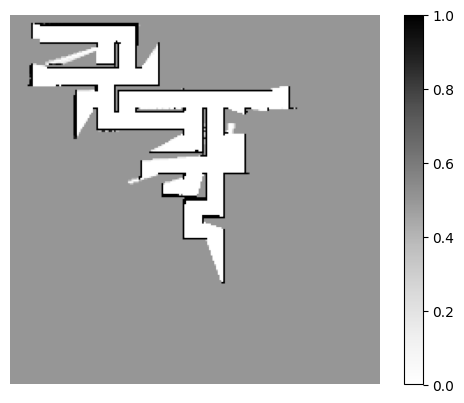

In [13]:
plot_grid(grid)

# 